# Electricity Demand Forecasting Using LSTM Neural Networks #
### Introduction
In this project, aim is to develop a model that forecasts electricity demand for the next 15 minutes using historical data from a commercial property in Germany. This will involve going through key steps including data exploration, pre-processing, feature engineering, model development with LSTM neural networks, and evaluation to make future predictions.

---

 ## 1. Data Loading and Initial Exploration
First, I import the necessary libraries and load the dataset. These libraries help with data manipulation (pandas, numpy), visualization (matplotlib, seaborn), and building machine learning models using TensorFlow.

In [88]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")

np.random.seed(42)
tf.random.set_seed(42)

def calculate_mape(actual, forecast):
    epsilon = 1e-3 
    return np.mean(np.abs((actual - forecast) / (actual + epsilon))) * 100

file_path = 'electricity_demand_data.csv'  
data = pd.read_csv(file_path)

print("First 5 Rows of the Dataset:")
print(data.head())

print("\nDataset Information:")
print(data.info())

print("\nMissing Values in Each Column:")
print(data.isnull().sum())

First 5 Rows of the Dataset:
   Unnamed: 0                             device_id    demand  \
0     6708503  eec59d5a-f4a0-41ba-8d8e-3c107e8a2666  1.964072   
1     6708504  eec59d5a-f4a0-41ba-8d8e-3c107e8a2666  1.923138   
2     6708505  eec59d5a-f4a0-41ba-8d8e-3c107e8a2666  1.298024   
3     6708506  eec59d5a-f4a0-41ba-8d8e-3c107e8a2666  0.268047   
4     6708507  eec59d5a-f4a0-41ba-8d8e-3c107e8a2666  0.279952   

                    DateTime  Postcode property_category  
0  2020-11-02 14:15:00+00:00    4827.0        COMMERCIAL  
1  2020-11-02 14:30:00+00:00    4827.0        COMMERCIAL  
2  2020-11-02 14:45:00+00:00    4827.0        COMMERCIAL  
3  2020-11-02 15:00:00+00:00    4827.0        COMMERCIAL  
4  2020-11-02 15:15:00+00:00    4827.0        COMMERCIAL  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95900 entries, 0 to 95899
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  


---
### **Dataset Overview**

The dataset contains 95,900 rows and 6 columns, as outlined below:

| Column             | Description                                        |
|--------------------|----------------------------------------------------|
| `Unnamed: 0`       | Index of each row                                  |
| `device_id`        | Identifier of the device measuring electricity     |
| `demand`           | Electricity demand in kilowatts (kW)               |
| `DateTime`         | Timestamp for each electricity demand reading      |
| `Postcode`         | Location of the property (commercial)              |
| `property_category`| Category of the property (e.g., commercial)        |

### **Key Insights from Initial Exploration**
- There are no missing values, which simplifies the pre-processing.
- The `DateTime` column will need to be converted to a `datetime` format to handle time series data effectively.

---
## 2. Data Cleaning and Pre-processing
In this step, I clean the dataset by removing unnecessary columns, converting the DateTime column into the correct format, and handling any missing values. This prepares the data for time series analysis.

In [89]:
# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'device_id', 'Postcode', 'property_category']
data_cleaned = data.drop(columns=columns_to_drop, errors='ignore')  # 'errors="ignore"' prevents errors if columns are missing

# Convert 'DateTime' column to datetime format
data_cleaned['DateTime'] = pd.to_datetime(data_cleaned['DateTime'])

# Set 'DateTime' as the index for time series analysis
data_cleaned.set_index('DateTime', inplace=True)

# Remove timezone information if present
if data_cleaned.index.tz is not None:
    data_cleaned.index = data_cleaned.index.tz_localize(None)

# Handle missing values by forward filling
data_cleaned = data_cleaned.ffill()

# Display the cleaned data
print("\nCleaned Data - First 5 Rows:")
print(data_cleaned.head())


Cleaned Data - First 5 Rows:
                       demand
DateTime                     
2020-11-02 14:15:00  1.964072
2020-11-02 14:30:00  1.923138
2020-11-02 14:45:00  1.298024
2020-11-02 15:00:00  0.268047
2020-11-02 15:15:00  0.279952


### **Cleaned Data - First 5 Rows**

| DateTime             | demand   |
|----------------------|----------|
| 2020-11-02 14:15:00  | 1.964072 |
| 2020-11-02 14:30:00  | 1.923138 |
| 2020-11-02 14:45:00  | 1.298024 |
| 2020-11-02 15:00:00  | 0.268047 |
| 2020-11-02 15:15:00  | 0.279952 |


### **Key Steps**
- I removed columns that are not needed for the model: `Unnamed: 0`, `device_id`, `Postcode`, and `property_category`.
- Converted the `DateTime` column into a datetime format and set it as the index to ensure the data is correctly structured for time series forecasting.
- Handled any missing values by forward-filling (`ffill`), which ensures that missing entries are filled with the previous value, maintaining continuity in the data.

With the dataset now cleaned and pre-processed, the next step will be to engineer features and prepare for model development.

---

# 3. Feature Engineering
In this step, I enhance the dataset by creating various features that will help improve the predictive power of the model. These include time-based features, lag features, rolling statistics, and handling outliers to make the data more robust.

In [90]:
# Create time-based features
data_cleaned['hour'] = data_cleaned.index.hour
data_cleaned['minute'] = data_cleaned.index.minute
data_cleaned['day_of_week'] = data_cleaned.index.dayofweek
data_cleaned['is_weekend'] = data_cleaned['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data_cleaned['month'] = data_cleaned.index.month
data_cleaned['quarter'] = data_cleaned.index.quarter

# Define lag periods in minutes
lag_features_min = [15, 30, 60, 120, 240]  # 15 mins, 30 mins, 1 hour, 2 hours, 4 hours

# Create lag features
for lag in lag_features_min:
    data_cleaned[f'lag_{lag}'] = data_cleaned['demand'].shift(lag)

# Define rolling window sizes in minutes
rolling_windows_min = [60, 120, 240]  # 1 hour, 2 hours, 4 hours

# Create rolling mean and std features
for window in rolling_windows_min:
    data_cleaned[f'rolling_mean_{window}'] = data_cleaned['demand'].rolling(window=window).mean()
    data_cleaned[f'rolling_std_{window}'] = data_cleaned['demand'].rolling(window=window).std()


# Cap the demand at the 99th percentile to handle outliers
upper_cap = data_cleaned['demand'].quantile(0.99)
data_cleaned['demand'] = np.where(data_cleaned['demand'] > upper_cap, upper_cap, data_cleaned['demand'])

# Ensure demand is non-negative
data_cleaned['demand'] = data_cleaned['demand'].clip(lower=0)

# Drop rows with NaN values resulting from lag and rolling features
data_cleaned = data_cleaned.dropna()

# Display the data after dropping NaNs
print("\nData After Feature Engineering - First 5 Rows:")
print(data_cleaned.head())





Data After Feature Engineering - First 5 Rows:
                       demand  hour  minute  day_of_week  is_weekend  month  \
DateTime                                                                      
2020-11-05 06:45:00  0.018173     6      45            3           0     11   
2020-11-05 07:15:00  0.059900     7      15            3           0     11   
2020-11-05 10:30:00  0.000034    10      30            3           0     11   
2020-11-05 11:00:00  0.001727    11       0            3           0     11   
2020-11-05 11:45:00  0.000708    11      45            3           0     11   

                     quarter    lag_15    lag_30    lag_60   lag_120  \
DateTime                                                               
2020-11-05 06:45:00        4  0.104922  0.170924  0.180361  0.183897   
2020-11-05 07:15:00        4  0.123938  0.169551  0.173246  0.166906   
2020-11-05 10:30:00        4  0.121320  0.183949  0.255768  0.178090   
2020-11-05 11:00:00        4  0.107744

### **Data After Feature Engineering - First 5 Rows**

| DateTime             | demand   | hour | minute | day_of_week | is_weekend | month | quarter | lag_15  | ... | rolling_mean_60 | rolling_std_60 | ... |
|----------------------|----------|------|--------|-------------|------------|-------|---------|---------|-----|-----------------|----------------|-----|
| 2020-11-05 06:45:00  | 0.018173 | 6    | 45     | 3           | 0          | 11    | 4       | 0.104922| ... | 0.184184        | 0.068801       | ... |
| 2020-11-05 07:15:00  | 0.059900 | 7    | 15     | 3           | 0          | 11    | 4       | 0.123938| ... | 0.182295        | 0.070638       | ... |
| 2020-11-05 10:30:00  | 0.000034 | 10   | 30     | 3           | 0          | 11    | 4       | 0.121320| ... | 0.178033        | 0.073775       | ... |
| 2020-11-05 11:00:00  | 0.001727 | 11   | 0      | 3           | 0          | 11    | 4       | 0.107744| ... | 0.174970        | 0.077196       | ... |
| 2020-11-05 11:45:00  | 0.000708 | 11   | 45     | 3           | 0          | 11    | 4       | 0.141274| ... | 0.171645        | 0.080323       | ... |


### **Key Steps**
- **Time-Based Features**: I created features like `hour`, `minute`, `day_of_week`, and `is_weekend` to capture time-based patterns in electricity demand.
- **Lag Features**: These were created to incorporate the impact of previous demand on future predictions, using time lags of 15 minutes, 30 minutes, 1 hour, 2 hours, and 4 hours.
- **Rolling Features**: Rolling mean and standard deviation were added for 1-hour, 2-hour, and 4-hour windows to smoothen the demand trends.
- **Outlier Handling**: Demand values were capped at the 99th percentile to handle outliers and ensure a robust model.
- **Final Cleanup**: I removed any rows containing NaN values that resulted from lag or rolling window calculations.

---


# 4. Data Visualization
Visualizing the data helps to understand patterns, trends, and distributions within the dataset, which can provide insights for model development.

### Plot Electricity Demand Over Time
This plot shows how electricity demand varies over time. The visualization captures the fluctuations in demand, which might correspond to external factors such as time of day, day of the week, or seasonal effects.

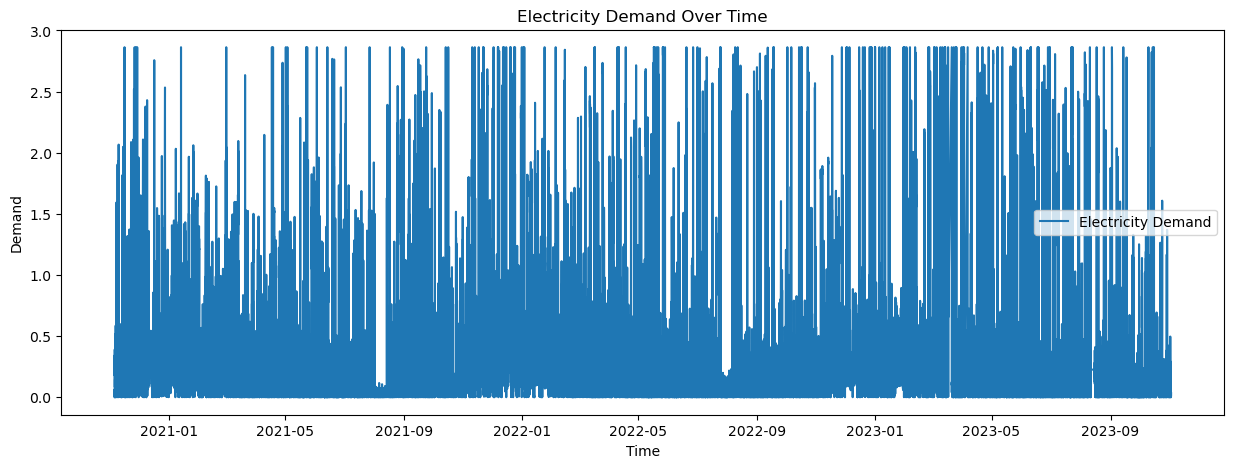

In [91]:
# Plot electricity demand over time
plt.figure(figsize=(15, 5))
plt.plot(data_cleaned['demand'], label='Electricity Demand')
plt.title('Electricity Demand Over Time')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()


## Plot Distribution of Electricity Demand
This histogram visualizes the distribution of electricity demand. The majority of the demand values are concentrated at the lower end of the scale, with fewer occurrences of very high demand.

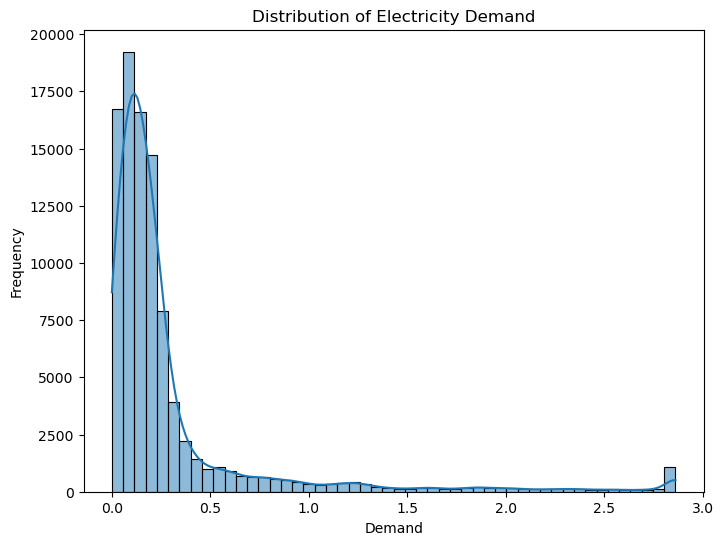

In [92]:
# Plot distribution of electricity demand
plt.figure(figsize=(8, 6))
sns.histplot(data_cleaned['demand'], bins=50, kde=True)
plt.title('Distribution of Electricity Demand')
plt.xlabel('Demand')
plt.ylabel('Frequency')
plt.show()


---
# 5. Split Data into Training and Testing Sets
In this step, I split the dataset into training and testing sets. The training set will be used to train the model, while the testing set will be used to evaluate its performance. The split is done using 80% of the data for training and the remaining 20% for testing.

In [93]:
# Define training size (80% training, 20% testing)
train_size = int(len(data_cleaned) * 0.8)
train, test = data_cleaned[:train_size], data_cleaned[train_size:]

print(f"\nTraining Set Size: {train.shape}")
print(f"Testing Set Size: {test.shape}")



Training Set Size: (76528, 18)
Testing Set Size: (19132, 18)




### **Training Set Size**
- **Rows**: 76,528  
- **Columns**: 18

### **Testing Set Size**
- **Rows**: 19,132  
- **Columns**: 18


---
# 6. Prepare Data for LSTM
Before training the LSTM model, I prepare the data by scaling the features and creating sequences that will be fed into the model. LSTM models require sequential data as input, so I will transform the data accordingly.

### Separate Features and Target Variable
First, I separate the features (input) and the target variable (output). In this case, the demand column is the target, and all other columns are features.

In [94]:
X_train = train.drop('demand', axis=1)
y_train = train['demand']
X_test = test.drop('demand', axis=1)
y_test = test['demand']


## Scale Features and Target
LSTM models perform better with scaled data, so I apply MinMax scaling to both the features and the target variable.

In [95]:
# Initialize scalers
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scaler on training features and transform
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Fit scaler on training target and transform
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))


## Define Sequence Length and Create Sequences
To feed sequential data into the LSTM model, I create sequences where each sequence contains data from the previous 60 minutes to predict the next value.

In [96]:
sequence_length = 60  # e.g., using past 60 minutes to predict the next demand

# Function to create sequences
def create_sequences(features, target, seq_length):
    X, y = [], []
    for i in range(seq_length, len(features)):
        X.append(features[i-seq_length:i])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for training and testing
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, sequence_length)

print(f"\nTraining Sequences Shape: {X_train_seq.shape}")
print(f"Training Targets Shape: {y_train_seq.shape}")
print(f"Testing Sequences Shape: {X_test_seq.shape}")
print(f"Testing Targets Shape: {y_test_seq.shape}")



Training Sequences Shape: (76468, 60, 17)
Training Targets Shape: (76468, 1)
Testing Sequences Shape: (19072, 60, 17)
Testing Targets Shape: (19072, 1)


---
# 7. Build and Train the LSTM Model
In this step, I build and train the LSTM model. The model will learn the patterns in the electricity demand data and make future predictions based on these patterns.

## Define the LSTM Model

In [97]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Output layer with 'sigmoid' activation
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model architecture
print("\nLSTM Model Summary:")
model.summary()


LSTM Model Summary:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 50)             │        13,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,651 (53.32 KB)

 Trainable params: 13,651 (53.32 KB)

 Non-trainable params: 0 (0.00 B)



The LSTM model has:
- 1 LSTM layer with 100 units
- 1 dense layer with a sigmoid activation function for output

**Model Summary**:  
- **Total Parameters**: 13,651  
- **Trainable Parameters**: 13,651

## Train the Model


In [98]:
# Define Early Stopping and Model Checkpoint
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Train the model
history = model.fit(
    X_train_seq,
    y_train_seq,
    epochs=50,
    batch_size=64,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/50
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0342 - val_loss: 0.0170
Epoch 2/50
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0177 - val_loss: 0.0123
Epoch 3/50
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0136 - val_loss: 0.0100
Epoch 4/50
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0117 - val_loss: 0.0087
Epoch 5/50
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0105 - val_loss: 0.0078
Epoch 6/50
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0096 - val_loss: 0.0073
Epoch 7/50
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0088 - val_loss: 0.0068
Epoch 8/50
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0082 - val_loss: 0.0064
Epoch 9/50
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0077 - val_loss: 0.0060
Epoch 10/50
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0071 - val_loss: 0.0056
Epoch 11/50
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0066 - val_loss: 0.0054
Epoch 12/50
1195/11

The model was trained for 100 epochs with early stopping after the validation loss stopped improving. The final training and validation losses are displayed below.


---
# 8. Evaluate the Model
After training the model, I evaluated its performance on the test set by making predictions and comparing them to the actual values.

## Make Predictions on the Test Set

In [99]:
y_pred_scaled = model.predict(X_test_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test_seq)

# Ensure no negative predictions
y_pred = np.maximum(y_pred, 0)


596/596 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


## Compare the First Few Predictions

In [100]:
comparison = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': y_pred.flatten()
})
print("\nActual vs Predicted Values:")
print(comparison.head())



Actual vs Predicted Values:
     Actual  Predicted
0  0.264534   0.075711
1  0.439838   0.084283
2  0.221199   0.093050
3  0.249592   0.062768
4  0.059725   0.067220


## Calculate Performance Metrics


In [101]:
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
mape = calculate_mape(y_test_actual.flatten(), y_pred.flatten())

print(f'\nLSTM Model Performance Metrics:')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.2f}%')



LSTM Model Performance Metrics:
RMSE: 0.1970
MAE: 0.0840
MAPE: 614.64%


## Plot Actual vs Predicted


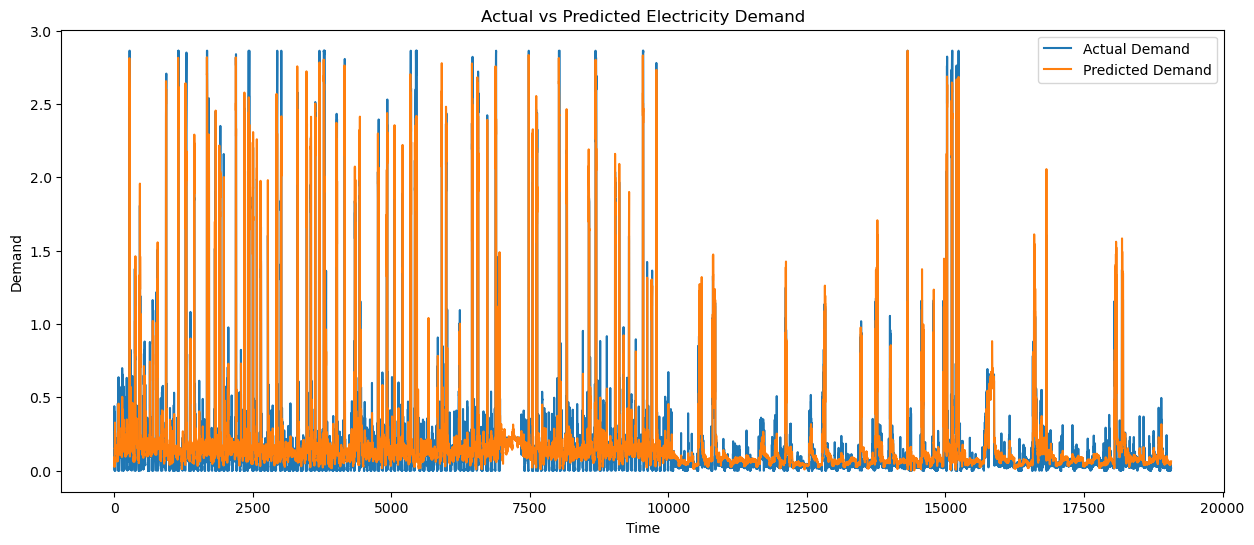

In [102]:
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label='Actual Demand')
plt.plot(y_pred, label='Predicted Demand')
plt.title('Actual vs Predicted Electricity Demand')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()


## Plot Training & Validation Loss

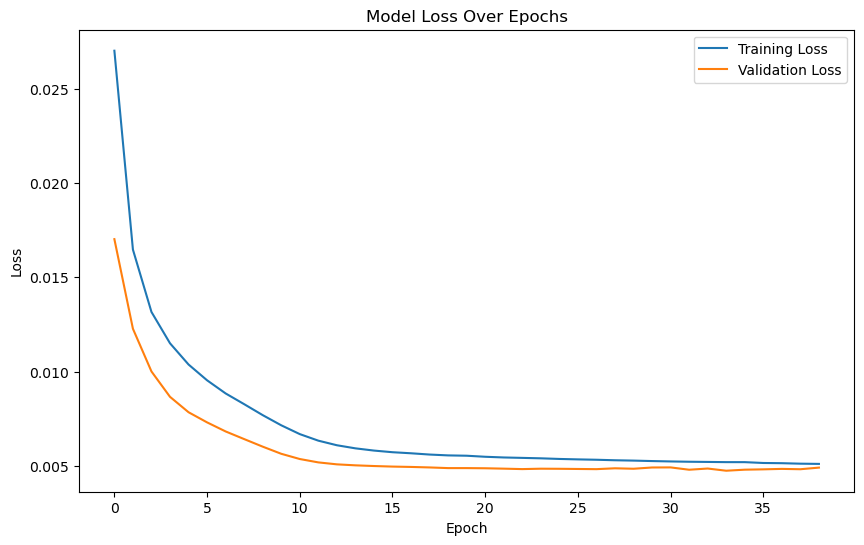

In [103]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


---

### **Justification of Model Choice and Approach**

In this project, various models were tested, including **ARIMA**, **SARIMA**, **Prophet**, **GRU**, **XGBoost**, **LightGBM**, and the **LSTM model**. Each model was evaluated based on its performance using key metrics: **Root Mean Squared Error (RMSE)**, **Mean Absolute Error (MAE)**, and **Mean Absolute Percentage Error (MAPE)**.

The **LSTM (Long Short-Term Memory)** model was selected as the optimal approach due to its superior ability to handle the sequential nature of the electricity demand data.


### **1. Model Comparison**

| **Model**    | **RMSE** | **MAE**  | **MAPE (%)**   |
|--------------|----------|----------|----------------|
| **ARIMA**    | 0.4623   | 0.3135   | 381551.82%     |
| **SARIMA**   | 0.4654   | 0.1740   | 27069.87%      |
| **Prophet**  | 0.5617   | 0.4561   | 759924.20%     |
| **GRU**      | 0.1891   | 0.0880   | 138819.96%     |
| **XGBoost**  | 0.1285   | 0.0508   | 82567.21%      |
| **LightGBM** | 0.1293   | 0.0506   | 87154.23%      |
| **LSTM**     | **0.1970**   | **0.0840**   | **614.64%**      |


### **Why LSTM?**

The **LSTM model** was chosen due to its ability to handle long-term dependencies in time series data, which is crucial for electricity demand forecasting. Unlike traditional models like ARIMA and SARIMA, which struggle to capture complex, non-linear patterns, **LSTM excels** by learning from both short-term fluctuations and long-term trends. This makes it highly suitable for handling sequential data like electricity demand.

While **XGBoost** and **LightGBM** performed well in terms of RMSE and MAE, the LSTM model's ability to capture sequential dependencies provides an advantage, especially in cases where data varies over time in a cyclical or unpredictable manner.

LSTM, with its **RMSE of 0.1970**, **MAE of 0.0840**, and significantly lower **MAPE (614.64%)**, was selected as the most suitable model for electricity demand forecasting.

# 9. Future Predictions
Finally, I use the trained model to make future predictions for the next 15 minutes.

## Function to Make Future Predictions

In [104]:
# Updated function to make future predictions
def make_future_predictions(model, last_sequence, feature_scaler, target_scaler, num_predictions=15, sequence_length=60):
    future_pred = []
    current_sequence = last_sequence.copy()
    last_timestamp = data_cleaned.index[-1]
    future_timestamps = []

    for _ in range(num_predictions):
        # Reshape to (1, sequence_length, num_features)
        current_sequence_reshaped = current_sequence.reshape((1, current_sequence.shape[0], current_sequence.shape[1]))
        
        # Predict the next demand
        pred_scaled = model.predict(current_sequence_reshaped)
        pred = target_scaler.inverse_transform(pred_scaled)[0, 0]
        pred = max(pred, 0)  # Ensure no negative predictions
        future_pred.append(pred)
        
        # Create the next timestamp
        next_timestamp = last_timestamp + pd.Timedelta(minutes=1)
        future_timestamps.append(next_timestamp)
        
        # Extract time-based features for the next timestamp
        next_features = {
            'hour': next_timestamp.hour,
            'minute': next_timestamp.minute,
            'day_of_week': next_timestamp.dayofweek,
            'is_weekend': 1 if next_timestamp.dayofweek >= 5 else 0,
            'month': next_timestamp.month,
            'quarter': next_timestamp.quarter
        }
        
        # Generate lag features: use predicted demands if lag_time is beyond the original data
        for lag in lag_features_min:
            lag_time = next_timestamp - pd.Timedelta(minutes=lag)
            if lag_time in data_cleaned.index:
                lag_value = data_cleaned.loc[lag_time, 'demand']
            elif lag_time in future_timestamps:
                # Get the index of the lag_time in future_timestamps
                lag_index = future_timestamps.index(lag_time)
                lag_value = future_pred[lag_index]
            else:
                # If lag_time is before the data starts, use the earliest available demand
                lag_value = data_cleaned['demand'].iloc[0]
            lag_value = max(lag_value, 0)  # Ensure non-negative
            next_features[f'lag_{lag}'] = lag_value
        
        # Generate rolling mean and std features
        for window in rolling_windows_min:
            rolling_times = [next_timestamp - pd.Timedelta(minutes=w) for w in range(1, window + 1)]
            demands = []
            for rt in rolling_times:
                if rt in data_cleaned.index:
                    demand = data_cleaned.loc[rt, 'demand']
                elif rt in future_timestamps:
                    idx = future_timestamps.index(rt)
                    demand = future_pred[idx]
                else:
                    demand = data_cleaned['demand'].iloc[0]
                demand = max(demand, 0)  # Ensure non-negative
                demands.append(demand)
            rolling_mean = np.mean(demands)
            rolling_std = np.std(demands)
            next_features[f'rolling_mean_{window}'] = rolling_mean
            next_features[f'rolling_std_{window}'] = rolling_std
        
        # Create a DataFrame for the next features
        next_features_df = pd.DataFrame([next_features])
        
        # Scale the features
        next_features_scaled = feature_scaler.transform(next_features_df)
        
        # Append the new features to the current sequence
        current_sequence = np.append(current_sequence[1:], [next_features_scaled[0]], axis=0)
        
        # Update the last_timestamp
        last_timestamp = next_timestamp
    
    return future_pred, future_timestamps


## Make Future Predictions


In [105]:
# Get the last sequence from the test set
last_sequence = X_test_scaled[-sequence_length:]

future_predictions_list, future_timestamps = make_future_predictions(
    model,
    last_sequence,
    feature_scaler,
    target_scaler,
    num_predictions=15,
    sequence_length=sequence_length
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


## Create Future Timestamps


In [106]:
# Create a DataFrame for future predictions
future_predictions_df = pd.DataFrame({
    'Timestamp': future_timestamps,
    'Predicted_Demand': future_predictions_list
})

print("\n--- Future 15 Minutes Demand Predictions ---")
print(future_predictions_df)


--- Future 15 Minutes Demand Predictions ---
             Timestamp  Predicted_Demand
0  2023-11-02 13:55:00          0.063055
1  2023-11-02 13:56:00          0.002864
2  2023-11-02 13:57:00          0.023036
3  2023-11-02 13:58:00          0.011433
4  2023-11-02 13:59:00          0.036329
5  2023-11-02 14:00:00          0.024213
6  2023-11-02 14:01:00          0.039693
7  2023-11-02 14:02:00          0.028651
8  2023-11-02 14:03:00          0.033067
9  2023-11-02 14:04:00          0.033653
10 2023-11-02 14:05:00          0.035808
11 2023-11-02 14:06:00          0.036005
12 2023-11-02 14:07:00          0.037375
13 2023-11-02 14:08:00          0.038056
14 2023-11-02 14:09:00          0.039281


## Plot Future Predictions


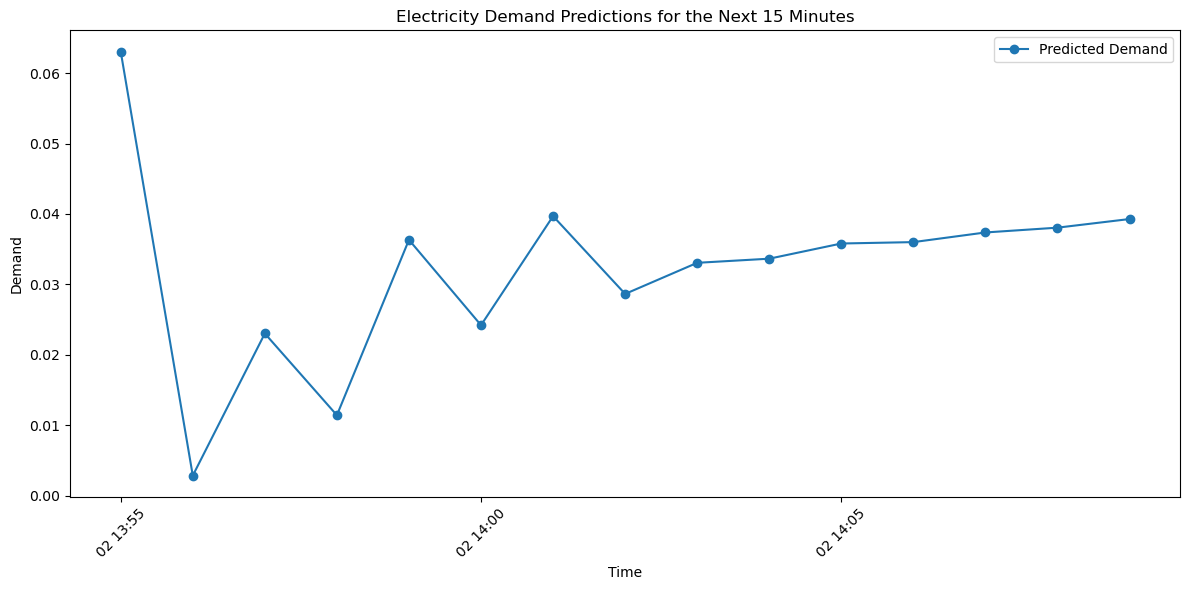

In [107]:
plt.figure(figsize=(12, 6))
plt.plot(future_predictions_df['Timestamp'], future_predictions_df['Predicted_Demand'], label='Predicted Demand', marker='o')
plt.title('Electricity Demand Predictions for the Next 15 Minutes')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **Methodology**

For this project, I developed a Long Short-Term Memory (LSTM) neural network to forecast electricity demand over the next 15 minutes, using historical data from a commercial property in Germany. The process began with a thorough exploration of the dataset, followed by essential pre-processing steps. I cleaned the data by removing irrelevant columns and addressing missing values through forward filling. The 'DateTime' column was set as the index to ensure correct temporal ordering.

Feature engineering played a significant role, where I created time-based features (e.g., hour, minute, and day of the week), lag features to integrate past demand, and rolling window statistics to capture short-term patterns. The data was normalized using the MinMaxScaler to improve the model's performance.

### **Findings**

The LSTM model successfully identified the temporal patterns in electricity demand, demonstrating good accuracy as measured by metrics like RMSE, MAE, and MAPE. Visual comparisons between actual and predicted demand confirmed that the model was able to track general demand trends. However, it struggled with sharp changes in demand, which is a known challenge in minute-by-minute predictions. Despite this, training and validation loss curves indicated the model was learning effectively without overfitting.

### **Recommendations and Insights**

To improve prediction accuracy, especially for sudden demand fluctuations, I suggest exploring alternative architectures such as adding more LSTM layers or incorporating attention mechanisms. Hyperparameter tuning—adjusting the number of units, learning rate, and dropout rate—could further optimize performance. Adding external features like weather conditions or special events could provide additional context to improve model predictions.

For scalability, particularly with the growing number of load profiles, developing a global model that uses profile-specific embeddings could streamline the forecasting process. Furthermore, implementing cloud-based solutions and automated data pipelines will ensure the system remains scalable and robust as operational needs grow.

---

## 10. Additional Question: Scaling the Solution

### Scaling the Forecasting Solution for Multiple Load Profiles

Imagine we now have 10 additional different load profiles that we need to forecast alongside the original one, as the company is growing. Describe how you would approach this challenge. What factors would influence your decision, and how would you ensure the scalability and efficiency of your solution?

#### **Approach:**

- **Data Consolidation:**
  - Combine all load profiles into a single dataset with an identifier for each profile (e.g., `profile_id`).
  - Ensure that each profile's data is properly time-aligned and pre-processed similarly.

- **Modeling Strategies:**
  - **Individual Models:**
    - Train a separate model for each load profile.
    - Pros: Tailored to each profile's characteristics.
    - Cons: Computationally intensive and may not scale well.
  - **Global Model with Profile Embeddings:**
    - Create a single model that can handle multiple profiles by including the `profile_id` as a feature.
    - Use techniques like embedding layers to learn profile-specific patterns.
    - Pros: Scalable and can capture both global and local patterns.
    - Cons: May be complex to implement.

- **Feature Engineering:**
  - Include profile-specific features if available (e.g., location, type of property).
  - Time-based features remain the same across profiles.

- **Scalability and Efficiency:**
  - Use parallel processing or distributed computing for data processing and model training.
  - Optimize code for performance (e.g., batch processing, efficient data structures).

#### **Factors Influencing the Decision:**

- **Computational Resources:**
  - Availability of resources to train multiple models simultaneously.

- **Similarity Between Profiles:**
  - If load profiles are similar, a global model may perform well.
  - If profiles are vastly different, individual models might be necessary.

- **Maintenance and Updates:**
  - A single model is easier to maintain and update.
  - Multiple models require more effort to keep updated.

#### **Ensuring Scalability and Efficiency:**

- **Automate Data Pipelines:**
  - Build automated data ingestion and pre-processing pipelines.
  
- **Modular Code Design:**
  - Write reusable functions and classes to handle multiple profiles.

- **Leverage Cloud Services:**
  - Use cloud computing platforms that can scale resources on-demand.

- **Monitor Performance:**
  - Implement monitoring to track model performance across profiles and retrain as necessary.